In [1]:
import pickle
import re

from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models import LsiModel
from gensim.models import LdaModel
from gensim import similarities
import gensim.corpora as corpora
import gensim

from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk

from FuzzyTM import FLSA_W

import matplotlib.pyplot as plt

In [2]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tomdewildt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
with open("../data/documents.pkl", "rb") as input_file:
    tm_data = pickle.load(input_file)   

In [4]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # Initialize regex tokenizer
    tokenizer = RegexpTokenizer(r"\w+")

    # Create English stop words list
    en_stop = set(stopwords.words("english"))

    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()

    # List for tokenized documents in loop
    texts = []

    # Loop through document list
    for i in doc_set:
        # Clean and tokenize document string
        raw = i.lower()    
        tokens = tokenizer.tokenize(raw)

        # Remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]

        # Stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]

        # Add tokens to list
        texts.append(stemmed_tokens)

    return texts

In [5]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

    # Generate LSA model
    return dictionary, doc_term_matrix

In [6]:
def create_gensim_lsa_model(doc_clean, number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)

    # Generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)

    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))

    return lsamodel

In [7]:
def create_gensim_lda_model(doc_clean, number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)

    # Generate LDA model
    ldamodel = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word=dictionary, passes=10, update_every=1, chunksize=10, alpha="auto")

    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))

    return ldamodel

In [8]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3, tm="lda"):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []

    for topic_num in range(start, stop, step):
        if tm == "lsa":
            model = LsiModel(doc_term_matrix, num_topics=topic_num, id2word=dictionary)
        else:
            model = LdaModel(doc_term_matrix, num_topics=topic_num, id2word=dictionary, passes=10, update_every=1, chunksize=10, alpha="auto")

        model_list.append(model)

        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [9]:
clean_text = preprocess_data(tm_data)

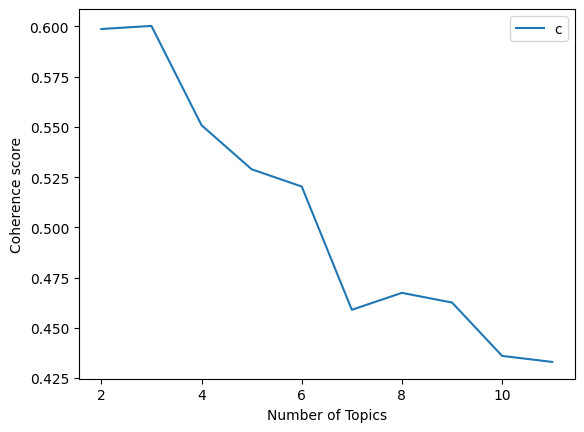

In [10]:
def plot_graph(doc_clean, start, stop, step, t_m="lda"):
    dictionary,doc_term_matrix = prepare_corpus(clean_text)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start, step, tm=t_m)

    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc="best")
    plt.show()

start, stop, step = 2, 12, 1
plot_graph(clean_text, start, stop, step, t_m="lsa")

In [11]:
len(tm_data[:500])

500

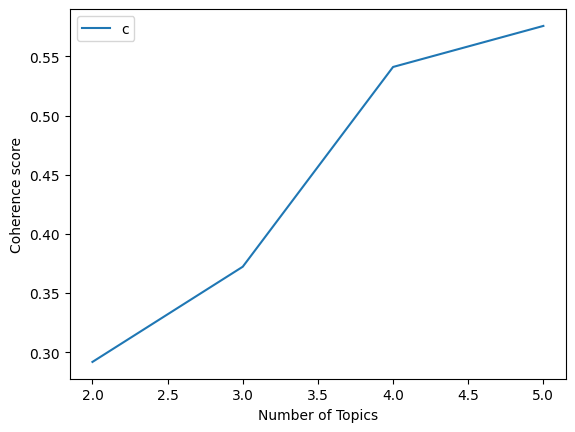

In [12]:
clean_text = preprocess_data(tm_data[:500])

start, stop, step = 2, 6, 1
plot_graph(clean_text, start, stop, step, t_m="lda")

In [13]:
# LSA Model
words = 10
new_number_of_topics = 4

model = create_gensim_lsa_model(clean_text, new_number_of_topics, words)
topic_words = model.print_topics(num_topics=new_number_of_topics, num_words=words)

for i, topic in enumerate(topic_words):
    print("Topic ", i, ":", re.findall(r'"(.*?)"', topic[1]))

[(0, '0.815*"â" + 0.147*"trump" + 0.145*"said" + 0.114*"say" + 0.087*"vote" + 0.087*"would" + 0.083*"one" + 0.081*"peopl" + 0.081*"year" + 0.073*"campaign"'), (1, '0.446*"trump" + -0.198*"say" + -0.186*"hammond" + -0.185*"year" + 0.178*"presid" + -0.167*"statement" + -0.152*"brexit" + -0.143*"govern" + 0.142*"â" + -0.139*"autumn"'), (2, '-0.356*"poll" + -0.355*"vote" + 0.225*"trump" + -0.215*"remain" + -0.185*"leav" + 0.184*"statement" + 0.175*"hammond" + -0.168*"station" + 0.160*"say" + -0.134*"referendum"'), (3, '0.417*"trump" + -0.367*"â" + 0.227*"presid" + 0.227*"elect" + 0.217*"vote" + 0.188*"poll" + 0.127*"eu" + 0.125*"campaign" + 0.125*"remain" + 0.118*"obama"')]
Topic  0 : ['â', 'trump', 'said', 'say', 'vote', 'would', 'one', 'peopl', 'year', 'campaign']
Topic  1 : ['trump', 'say', 'hammond', 'year', 'presid', 'statement', 'brexit', 'govern', 'â', 'autumn']
Topic  2 : ['poll', 'vote', 'trump', 'remain', 'leav', 'statement', 'hammond', 'station', 'say', 'referendum']
Topic  3 : 

In [14]:
# LDA Model
words = 10
new_number_of_topics = 5

model = create_gensim_lda_model(clean_text, new_number_of_topics,words)
topic_words = model.print_topics(num_topics=new_number_of_topics, num_words=words)

for i, topic in enumerate(topic_words):
    print("Topic ", i, ":", re.findall(r'"(.*?)"', topic[1]))

[(0, '0.022*"â" + 0.012*"bank" + 0.010*"said" + 0.009*"eu" + 0.008*"govern" + 0.008*"year" + 0.006*"uk" + 0.006*"would" + 0.005*"brexit" + 0.004*"market"'), (1, '0.021*"film" + 0.009*"play" + 0.008*"music" + 0.007*"movi" + 0.007*"star" + 0.006*"stori" + 0.006*"song" + 0.005*"album" + 0.005*"love" + 0.005*"war"'), (2, '0.025*"min" + 0.012*"leagu" + 0.011*"villa" + 0.010*"game" + 0.010*"season" + 0.009*"goal" + 0.009*"team" + 0.009*"player" + 0.008*"everton" + 0.006*"citi"'), (3, '0.025*"health" + 0.012*"patient" + 0.012*"nh" + 0.011*"depress" + 0.011*"studi" + 0.010*"research" + 0.008*"antidepress" + 0.008*"mental" + 0.008*"test" + 0.008*"care"'), (4, '0.058*"â" + 0.008*"said" + 0.007*"trump" + 0.006*"would" + 0.006*"one" + 0.006*"say" + 0.005*"time" + 0.005*"go" + 0.005*"like" + 0.004*"peopl"')]
Topic  0 : ['â', 'bank', 'said', 'eu', 'govern', 'year', 'uk', 'would', 'brexit', 'market']
Topic  1 : ['film', 'play', 'music', 'movi', 'star', 'stori', 'song', 'album', 'love', 'war']
Topic  

In [15]:
# Initialize model
flsaW = FLSA_W(
    input_file=clean_text,
    num_topics=20,
    num_words=10,
)

# Train topic model and obtain to matrices
pwgt, ptgd = flsaW.get_matrices()

# Get topics
topics = flsaW.show_topics(representation="words")

print(topics)

# Evaluation
coherence = flsaW.get_coherence_score(input_file=clean_text, topics=topics)
diversity = flsaW.get_diversity_score(topics=topics)
interpretability = flsaW.get_interpretability_score(input_file=clean_text, topics=topics)

print("Coherence score: ", str(coherence), "Diversity score:", str(diversity), "Interpretability score: ", str(interpretability), sep="\n")

[['like', 'recent', 'think', 'far', 'give', 'number', 'anoth', 'head', 'follow', 'world'], ['count', 'nigel', 'bet', 'poll', 'flood', 'weather', 'constitu', 'dayâ', 'rain', 'undecid'], ['product', 'cost', 'tackl', 'fund', 'chart', 'pay', 'path', 'balanc', 'chariti', 'increas'], ['level', 'although', 'current', '000', 'john', 'reveal', 'former', 'respons', 'explain', 'given'], ['break', 'case', 'parti', 'forc', 'fight', 'thought', 'top', 'alway', 'media', 'interview'], ['artist', 'attitud', 'pop', 'technolog', '2011', 'band', 'fashion', 'embarrass', 'festiv', 'sister'], ['summer', 'digit', 'bodi', 'truth', 'admit', 'seri', 'adopt', 'modern', 'profil', 'avail'], ['whose', 'age', 'industri', 'prospect', 'grow', 'death', 'defend', 'along', 'alleg', 'compani'], ['freedom', 'imag', 'surg', 'treat', 'influenc', 'arguabl', 'histor', 'occasion', 'extens', 'william'], ['reason', 'hold', 'œthe', 'return', 'arriv', 'worri', 'theyâ', 'across', 'emerg', 'yearâ'], ['spend', 'credit', 'cut', 'governme